In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

C:\Users\Admin\AppData\Local\Temp\ipykernel_7844\2058423583.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")


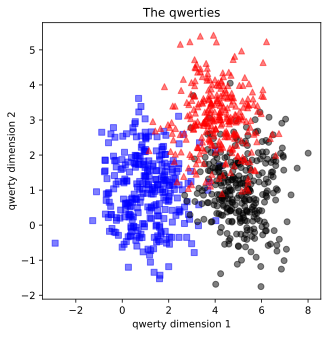

In [2]:
# create data

nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 3 ]

# generate data
a = [ A[0] + np.random.randn(nPerClust)*blur, A[1] + np.random.randn(nPerClust)*blur]
b = [ B[0] + np.random.randn(nPerClust)*blur, B[1] + np.random.randn(nPerClust)*blur]
c = [ C[0] + np.random.randn(nPerClust)*blur, C[1] + np.random.randn(nPerClust)*blur]


# true labels
labels_np = np.hstack((np.zeros((nPerClust)), np.ones((nPerClust)), 1 + np.ones((nPerClust))))

# concatenate into a matrix
data_np = np.hstack((a, b, c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()

# show the data
fig = plt.figure(figsize = (5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], "bs", alpha = .5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], "ko", alpha = .5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], "r^", alpha = .5)
plt.title("The qwerties")
plt.xlabel("qwerty dimension 1")
plt.ylabel("qwerty dimension 2")
plt.show()

In [3]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 0.11)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [4]:
# create a class for the model
def createTheQwertyNet(optimizerAlgo):
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            # input layer
            self.input = nn.Linear(2, 8)

            # hidden layer
            self.fc1 = nn.Linear(8, 8)

            # output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer
    optifun = getattr(torch.optim, optimizerAlgo)
    optimizer = optifun(net.parameters(), lr = .01)

    return net, lossfun, optimizer

In [5]:
# test the model with optimizer type as input

optim = createTheQwertyNet("RMSprop")[2]
optim

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

In [6]:
 # train the model

# training parameter
numepochs = 50

def trainTheModel(optimizerType):

    # create a new model
    net, lossfun, optimizer = createTheQwertyNet(optimizerType)
    
    trainAcc = []
    testAcc = []
    losses = torch.zeros(numepochs)
    
    # train the model
    for epochi in range(numepochs):

        # activate training mode
        net.train()
        
        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            matches = torch.argmax(yHat, axis = 1) == y # booleans (false/true); selects the class with the highest predicted probability for each input.
            # The == operator compares the predicted class to the actual class, returning a Boolean tensor (True for correct predictions, False for incorrect).
            matchesNumeric = matches.float() # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # avg and * by 100
            batchAcc.append(accuracyPct)
            
        # now that we've trained through the batches, get avg training accuracy
        trainAcc.append(np.mean(batchAcc))

        # get avg losses over the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval() # activate testing mode
        X, y = next(iter(test_loader))  # extract X, y from test dataloader
        with torch.no_grad(): # deactivates auto grad
            yHat = net(X)

        # compute test accuracy
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis = 1) == y).float()))
        
    # function output
    return trainAcc, testAcc, losses, net

In [7]:
def plotTheResults(optimizerType):

    # compute accuracy over entire dataset (train+test)
    yHat = net(data)
    predictions = torch.argmax(yHat, axis = 1)
    accuracy = (predictions == labels).float()
    totalAcc = torch.mean(100 * accuracy).item()

    # and accuracy by group
    accuracyByGroup = np.zeros(3)
    for i in range(3):
        accuracyByGroup[i] = 100 * torch.mean(accuracy[labels == i])

    # create the figure
    fig, ax = plt.subplots(2, 2, figsize=(10, 6))

    # plot the loss function
    ax[0, 0].plot(losses.detach())
    ax[0, 0].set_ylabel("Loss")
    ax[0, 0].set_xlabel("Epoch")
    ax[0, 0].set_title(f"{optimizerType}: Losses")

    # plot the accuracy functions
    ax[0, 1].plot(trainAcc, label = "Train")
    ax[0, 1].plot(testAcc, label = "Test")
    ax[0, 1].set_ylabel("Accuracy (%)")
    ax[0, 1].set_xlabel("Epoch")
    ax[0, 1].set_title(f"{optimizerType}: Accuracy")
    ax[0, 1].legend()

    # plot overall by group
    ax[1, 0].bar(range(3), accuracyByGroup)
    ax[1, 0].set_ylim([np.min(accuracyByGroup) - 5, np.max(accuracyByGroup) + 5])
    ax[1, 0].set_xticks([0, 1, 2])
    ax[1, 0].set_xlabel("Group")
    ax[1, 0].set_title(f"{optimizerType}: Accuracy by group")

    # scatterplot of correct and incorrect labelled data
    colorShapes = ["bs", "ko", "g^"] #  data markers
    for i in range(3):
        # plot all data points
        ax[1, 1].plot(data[labels == i, 0], data[labels == i, 1], colorShapes[i], alpha = .3, label = f"Group {i}")

        # cross-out the incorrect ones
        idxErr = (accuracy == 0) & (labels == i)
        ax[1, 1].plot(data[idxErr, 0], data[idxErr, 1], "rx")

    ax[1, 1].set_title(f"{optimizerType}: Total accuracy: {totalAcc: .2f}%")
    ax[1, 1].set_xlabel("Qwerty dimension 1")
    ax[1, 1].set_ylabel("Qwerty dimension 2")
    ax[1, 1].legend()

    plt.tight_layout()
    plt.show()

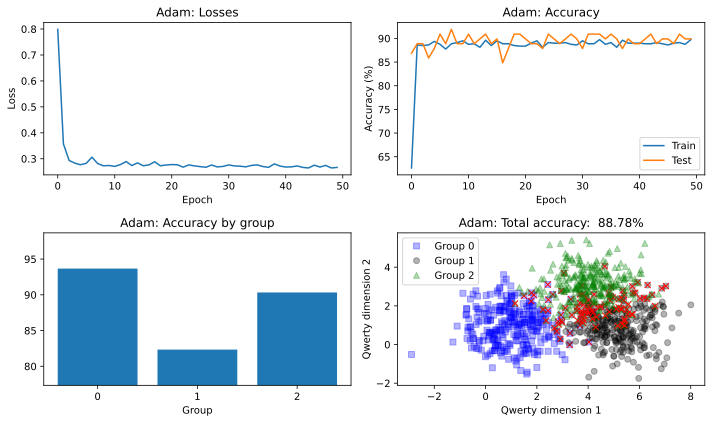

In [9]:
# run the model for one optimizer
optimizerType = "Adam"
trainAcc, testAcc, losses, net = trainTheModel(optimizerType)

# visualize
plotTheResults(optimizerType)

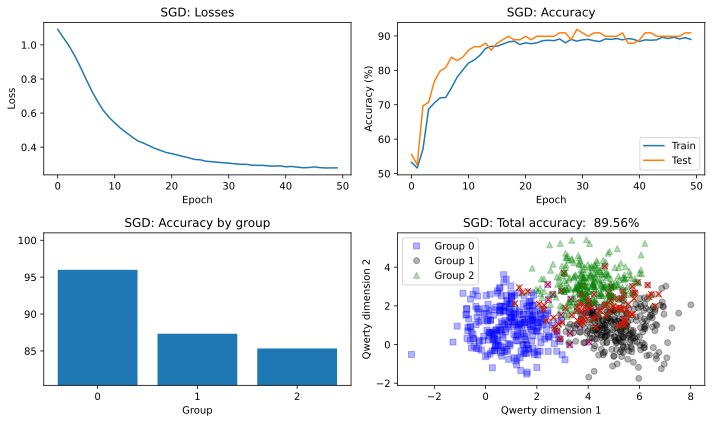

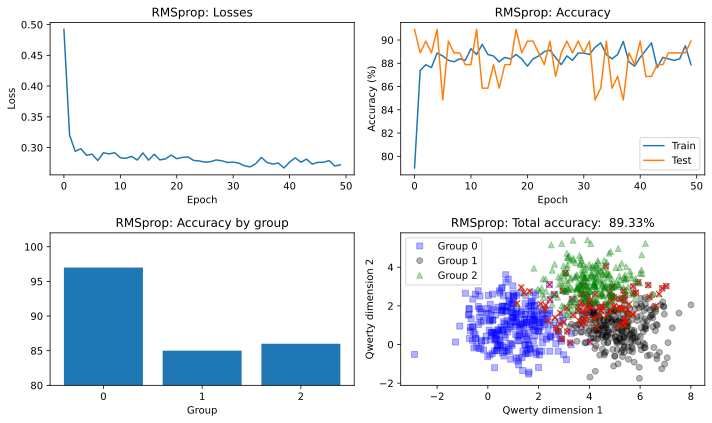

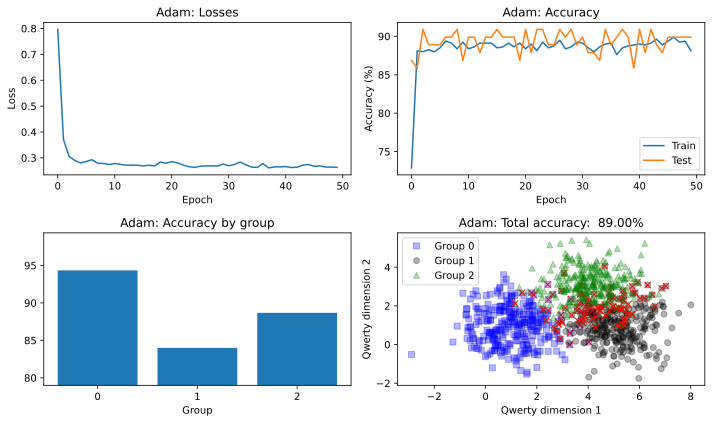

['SGD: train  89.1%, test  90.2%',
 'RMSprop: train  88.6%, test  88.5%',
 'Adam: train  89.2%, test  89.6%']

In [10]:
# now run thru all of them

# average performance
performance = []

for opto in ["SGD", "RMSprop", "Adam"]:
    trainAcc, testAcc, losses, net = trainTheModel(opto)
    plotTheResults(opto)

    # store the final results
    train = np.mean(trainAcc[-10:])
    test = np.mean(testAcc[-10:])

    performance.append(f"{opto}: train {train: .1f}%, test {test: .1f}%")

performance